## Quantum Amplitude Estimation Financial Services Uses Cases

### Introduction
This jupyter shows how quantum amplitude estimation can be used for credit risk analysis
providing a quadratical advantage over other classical methods as monthecarlo.

The jupyter is based on the following papers:
- <a href="https://www.nature.com/articles/s41534-019-0130-6">Quantum Risk Analysis. Stefan Woerner, Daniel J. Egger.</a> [Woerner2019]
- <a href="https://arxiv.org/abs/1907.03044">Credit Risk Analysis using Quantum Computers. Egger et al. (2019)</a> [Egger2019]

A general introduction to QAE can be found in the following paper and tutorial:
- <a href="http://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Gilles Brassard et al.</a>
- <a href="../../amplitude_estimation.ipynb">Qiskit Tutorial on Quantum Amplitude Estimation</a>

Please import the following libraries, that will be required during the execution of this notebook. If your system lacks any of these libraries, use ```pip install --user -r requirements.txt``` in a command line, within this notebook's folder, to ensure that all required libraries are installed.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import IntegerComparator
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation, AmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation

### 1) Uncertainty model

#### Theoretical overview

In this jupyter we want to analyze the credit risk of a portfolio of $K$ assets.
The default probability of every asset $k$ follows a *Gaussian Conditional Independence* model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

The problem is defined by the following parameters:
- number of qubits used to represent $Z$, denoted by $n_z$
- truncation value for $Z$, denoted by $z_{\text{max}}$, i.e., Z is assumed to take $2^{n_z}$ equidistant values in $\{-z_{max}, ..., +z_{max}\}$ 
- the base default probabilities for each asset $p_0^k \in (0, 1)$, $k=1, ..., K$
- sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0, 1)$

The objective of this module is creating a quantum state in a register of $n_z$ qubits that represents $Z$ following a standard normal distribution. This state is then used to control single qubit Y-rotations on a second qubit register of $K$ qubits, where a $|1\rangle$ state of qubit $k$ represents the default event of asset $k$. The resulting quantum state can be written as

$$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K 
\left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right),$$

where we denote by $z_i$ the $i$-th value of the discretized and truncated $Z$ [Egger2019].

#### Practical implementation

In [2]:
# set the problem parameters
n_z = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25]
rhos = [0.1, 0.05]
K = len(p_zeros)

In [3]:
from qiskit.finance.applications import GaussianConditionalIndependenceModel as GCI
u = GCI(n_z, z_max, p_zeros, rhos)

In [4]:
u.draw()

┌───────┐┌─────────┐┌─────────┐
q_0: ┤0      ├┤0        ├┤0        ├
     │  P(X) ││         ││         │
q_1: ┤1      ├┤1 LinRot ├┤1        ├
     └───────┘│         ││  LinRot │
q_2: ─────────┤2        ├┤         ├
              └─────────┘│         │
q_3: ────────────────────┤2        ├
                         └─────────┘

#### Ploting the probability distribution of the random variable Z

In [5]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend('statevector_simulator'))

In [6]:
# measuring for characterizing the probability distribution of Z
p_z = np.zeros(2**n_z)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2

    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob


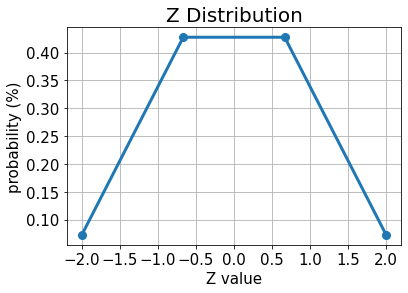

In [7]:
# plot results for Z
plt.plot(z_values, p_z, 'o-', linewidth=3, markersize=8)
plt.grid()
plt.xlabel('Z value', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Z Distribution', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### Computing the probability distribution of the different losses

In [9]:
lgd = [1, 2]

# run the circuit 
# Use the state vector simulator to execute the circuit and store the result in the variable job
##################### Code here #############################################
job = execute(u, backend=Aer.get_backend('statevector_simulator'))
#############################################################################

# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits



# from the job.result().get_statevector() results build a vector for the different values of loss and
#other vector for the different probabilities of default 

################################################ Code here ####################
for i, a in enumerate(job.result().get_statevector()):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2

    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])




No handles with labels found to put in legend.


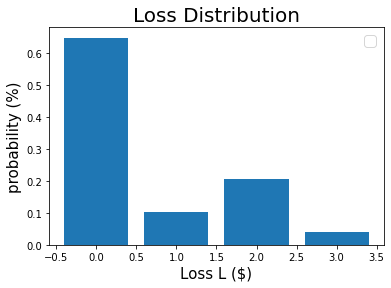

In [10]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses,pdf)
plt.legend(fontsize=15)
plt.xlabel('Loss L ($)', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Loss Distribution', size=20)
plt.show()

### Exercise 1) Compute expected Loss of for the former probability distribution without using Quantum Amplitude Estimation

(10 minutes)

In [ ]:
# Compute the expected loss by using the array of default values and probabilities
######################################### Code Here ###################################
expected_loss = 
#######################################################################################


print(expected_loss)

##### Solution

In [64]:
# Compute the expected loss by using the array of default values and probabilities
######################################### Code Here ###################################
expected_loss = np.dot(values, probabilities)
#######################################################################################


print(expected_loss)

0.6408668834510435


### 2) QAE for computing Expected Loss

once we have mappead the uncertainty function to a quantum state is easy to estimate the expected loss, we first apply a weighted sum operator to sum up individual losses to total loss:

$$ \mathcal{S}: |x_1, ..., x_K \rangle_K |0\rangle_{n_S} \mapsto |x_1, ..., x_K \rangle_K |\lambda_1x_1 + ... + \lambda_K x_K\rangle_{n_S}. $$

The required number of qubits to represent the result is given by

$$ n_s = \lfloor \log_2( \lambda_1 + ... + \lambda_K ) \rfloor + 1. $$

Once we have the total loss distribution in a quantum register, we can use the techniques described in [Woerner2019] to map a total loss $L \in \{0, ..., 2^{n_s}-1\}$ to the amplitude of an objective qubit by an operator

$$ | L \rangle_{n_s}|0\rangle \mapsto 
| L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right), $$

which allows to run amplitude estimation to evaluate the expected loss.

In [62]:
#Documentation: https://qiskit.org/documentation/stubs/qiskit.circuit.library.WeightedAdder.html

In [14]:
# set problem parameters
n_z = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25]
rhos = [0.1, 0.05]
K = len(p_zeros)
lgd = [1, 2]

In [15]:
# add Z qubits with weight/loss 0
from qiskit.circuit.library import WeightedAdder
agg = WeightedAdder(n_z + K, [0]*n_z + lgd)

In [16]:
from qiskit.circuit.library import LinearAmplitudeFunction

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes, 
    offset=offsets, 
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits-1),  
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

In [17]:
## Create the state preparation circuit:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, 'state')
qr_sum = QuantumRegister(agg.num_sum_qubits, 'sum')
qr_carry = QuantumRegister(agg.num_carry_qubits, 'carry')
qr_obj = QuantumRegister(1, 'objective')

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

┌───────┐┌────────┐      ┌───────────┐
    state_0: ┤0      ├┤0       ├──────┤0          ├
             │       ││        │      │           │
    state_1: ┤1      ├┤1       ├──────┤1          ├
             │  P(X) ││        │      │           │
    state_2: ┤2      ├┤2       ├──────┤2          ├
             │       ││        │      │           │
    state_3: ┤3      ├┤3       ├──────┤3          ├
             └───────┘│  adder │┌────┐│  adder_dg │
objective_0: ─────────┤        ├┤2   ├┤           ├
                      │        ││    ││           │
      sum_0: ─────────┤4       ├┤0 F ├┤4          ├
                      │        ││    ││           │
      sum_1: ─────────┤5       ├┤1   ├┤5          ├
                      │        │└────┘│           │
    carry_0: ─────────┤6       ├──────┤6          ├
                      └────────┘      └───────────┘

### Exercise 2) Compute the Expected Loss using:

1) Iterative Quantum Amplitude Estimation algorithm (https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.IterativeAmplitudeEstimation.html)

2) Canonical Quantum Amplitude Estimation algorithm (https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.AmplitudeEstimation.html)

3) Maximum likelihood quantum amplitude estimation algorithm (https://qiskit.org/documentation/stubs/qiskit.algorithms.MaximumLikelihoodAmplitudeEstimation.html)

Compare with the theoretical value obtained in the previous exercise

(20 minutes)

#### Exercise

Iterative Quantum Amplitude Estimation

In [ ]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
#################### code here ###############################################



#############################################################################


#print results 
###################### code here ############################################


#############################################################################

In [31]:
#Comparing with the theoretical value (0.6408668834510435)
#Compute the relative error comparing with the theoretical value:
################### code here ###############################################


#############################################################################

Canonical Quantum Amplitude Estimation

In [ ]:
#Set the number of evaluation qubits
num_eval_qubits=6

# construct amplitude estimation 
#################### code here ###############################################



#############################################################################


#print results 
###################### code here ############################################


#############################################################################

In [ ]:
#Comparing with the theoretical value (0.6408668834510435)
#Compute the relative error comparing with the theoretical value:
################### code here ###############################################


#############################################################################

Maximum likelihood Quantum Amplitude Estimation

In [ ]:
#Set the parameters
evaluation_schedule=6

# construct amplitude estimation 
#################### code here ###############################################



#############################################################################


#print results 
###################### code here ############################################


#############################################################################

In [ ]:
#Comparing with the theoretical value (0.6408668834510435)
#Compute the relative error comparing with the theoretical value:
################### code here ###############################################


#############################################################################

#### Solution

Iterative Quantum Amplitude Estimation

In [14]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
ae = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                  epsilon=epsilon, alpha=alpha,
                                  objective_qubits=[len(qr_state)],
                                  post_processing=objective.post_processing)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

# print results
conf_int = np.array(result['confidence_interval'])

print('Estimated value:\t%.4f' % result['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Estimated value:	0.6647
Confidence interval: 	[0.6466, 0.6828]


Compare with the value obtained in the previous exercise

In [24]:
#Comparing with the theoretical value (0.6408668834510435)
#Compute the relative error comparing with the theoretical value:
Theoretical_value=0.6408668834510435
Calculated_value=0.6647
rel_error=(Calculated_value-Theoretical_value)*100/Theoretical_value
print("The relative error is ", rel_error,"%")

The relative error is  3.718887207998027 %


Canonical Quantum Amplitude Estimation

In [26]:
#Set the parameters
num_eval_qubits=6

ae = AmplitudeEstimation(num_eval_qubits=num_eval_qubits,
                                  state_preparation=state_preparation,
                                  objective_qubits=[len(qr_state)],
                                  post_processing=objective.post_processing)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=2024)
result

{'a_estimation': 0.4024548, 'confidence_interval': [0.660895791744198, 0.6696674287130038], 'estimation': 0.7548095637653975, 'num_oracle_queries': 127512, 'ml_value': 0.39073929950135544, 'mapped_a_samples': [0.0024076, 0.0096074, 0.0215298, 0.0380602, 0.0590394, 0.0842652, 0.1134948, 0.1464466, 0.1828034, 0.2222149, 0.2643016, 0.3086583, 0.3548577, 0.4024548, 0.4509914, 0.5, 0.5490086, 0.5975452, 0.6451423, 0.6913417, 0.7356984, 0.7777851, 0.8171966, 0.8535534, 0.8865052, 0.9157348, 0.9409606, 0.9975924, 1.0], 'probabilities': [0.0014822134387351778, 0.0004940711462450593, 0.0009881422924901185, 0.001976284584980237, 0.0004940711462450593, 0.001976284584980237, 0.0009881422924901185, 0.0014822134387351778, 0.0029644268774703555, 0.0014822134387351778, 0.008893280632411068, 0.017786561264822136, 0.08053359683794467, 0.8176877470355731, 0.03211462450592885, 0.010869565217391304, 0.00642292490118577, 0.0009881422924901185, 0.0014822134387351778, 0.0009881422924901185, 0.0004940711462450

Compare with the value obtained in the previous exercise

In [29]:
#Comparing with the theoretical value (0.6408668834510435)
#Compute the relative error comparing with the theoretical value:
Theoretical_value=0.6408668834510435
Calculated_value=0.7548095637653975
rel_error=(Calculated_value-Theoretical_value)*100/Theoretical_value
print("The relative error is ", rel_error,"%")

The relative error is  17.77946142274931 %


Maximun likelihood Quantum Amplitude Estimation

In [28]:
#Set the parameters
evaluation_schedule=6

mae=MaximumLikelihoodAmplitudeEstimation(evaluation_schedule, state_preparation=state_preparation,  objective_qubits=[len(qr_state)],
                                  post_processing=objective.post_processing)
result_maxlike_ae = mae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=5000)
result_maxlike_ae

{'a_estimation': 0.3905532581010174, 'confidence_interval': [0.6625224127040987, 0.6652545493574114], 'estimation': 0.663888481030755, 'num_oracle_queries': 315000, 'circuit_results': [{'0': 3035, '1': 1965}, {'0': 986, '1': 4014}, {'0': 4753, '1': 247}, {'0': 4787, '1': 213}, {'0': 1026, '1': 3974}, {'0': 4593, '1': 407}, {'0': 4948, '1': 52}], 'theta': 0.6750580091787691, 'fisher_information': 120136251.2615256}

Compare with the value obtained in the previous exercise

In [30]:
#Comparing with the theoretical value (0.6408668834510435)
#Compute the relative error comparing with the theoretical value:
Theoretical_value=0.6408668834510435
Calculated_value=0.663888481030755
rel_error=(Calculated_value-Theoretical_value)*100/Theoretical_value
print("The relative error is ", rel_error,"%")

The relative error is  3.592258887796034 %


### 3) QAE for computing Cumulative Distribution Function

Instead of the expected loss (which could also be estimated efficiently using classical techniques) we now estimate the cumulative distribution function (CDF) of the loss.
Classically, this either involves evaluating all the possible combinations of defaulting assets, or many classical samples in a Monte Carlo simulation. Algorithms based on QAE have the potential to significantly speed up this analysis in the future.

To estimate the CDF, i.e., the probability $ \mathbb{P}[L \leq x] $, we again apply $\mathcal{S}$ to compute the total loss, and then apply a comparator that for a given value $x$ acts as

$$ \mathcal{C}: |L\rangle_n|0> \mapsto 
\begin{cases} 
|L\rangle_n|1> & \text{if}\quad L \leq x \\
|L\rangle_n|0> & \text{if}\quad L > x.
\end{cases} $$

The resulting quantum state can be written as

$$ \sum_{L = 0}^{x} \sqrt{p_{L}}|L\rangle_{n_s}|1\rangle + 
\sum_{L = x+1}^{2^{n_s}-1} \sqrt{p_{L}}|L\rangle_{n_s}|0\rangle, $$

where we directly assume the summed up loss values and corresponding probabilities instead of presenting the details of the uncertainty model.

The CDF($x$) equals the probability of measuring $|1\rangle$ in the objective qubit and QAE can be directly used to estimate it.

In [18]:
# set x value to estimate the CDF
x_eval = 2
# Documentation https://qiskit.org/documentation/stubs/qiskit.circuit.library.IntegerComparator.html
comparator = IntegerComparator(agg.num_sum_qubits,  value=x_eval + 1,geq=False)
comparator.draw()

state_0: ──■──────────────■──
             │              │  
  state_1: ──┼────■─────────┼──
             │  ┌─┴─┐┌───┐  │  
compare_0: ──┼──┤ X ├┤ X ├──┼──
           ┌─┴─┐└─┬─┘└───┘┌─┴─┐
     a0_0: ┤ X ├──■───────┤ X ├
           └───┘          └───┘

In [19]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_sum = QuantumRegister(agg.num_sum_qubits, 'sum')
    qr_carry = QuantumRegister(agg.num_carry_qubits, 'carry')
    qr_obj = QuantumRegister(1, 'objective')
    qr_compare = QuantumRegister(1, 'compare')

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])
    
    return state_preparation
    
x_eval = 2

state_preparation = get_cdf_circuit(x_eval)
state_preparation.draw()

┌───────┐┌────────┐        
    state_0: ┤0      ├┤0       ├────────
             │       ││        │        
    state_1: ┤1      ├┤1       ├────────
             │  P(X) ││        │        
    state_2: ┤2      ├┤2       ├────────
             │       ││        │        
    state_3: ┤3      ├┤3       ├────────
             └───────┘│  adder │┌──────┐
objective_0: ─────────┤        ├┤2     ├
                      │        ││      │
      sum_0: ─────────┤4       ├┤0     ├
                      │        ││  cmp │
      sum_1: ─────────┤5       ├┤1     ├
                      │        ││      │
    carry_0: ─────────┤6       ├┤3     ├
                      └────────┘└──────┘

### Exercise 3) Use all the avaliables QAE methods for computing CDF for x_eval = 2

(15 minutes)

Iterative Quantum Amplitude estimation

In [ ]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05
# Code Here ############################


#########################################
# print results
conf_int = np.array(result_cdf['confidence_interval'])
print('Estimated value:\t%.4f' % result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Canonical Quantum Amplitude Estimation

In [ ]:
# Code Here ############################


#########################################
# print results
conf_int = np.array(result_cdf['confidence_interval'])
print('Estimated value:\t%.4f' % result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Maximun Likelihood Quantum Amplitude Estimation

In [ ]:
# Code Here ############################


#########################################
# print results
conf_int = np.array(result_cdf['confidence_interval'])
print('Estimated value:\t%.4f' % result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

#### Solution

Iterative Quantum Amplitude Estimation

In [21]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
ae_cdf = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                      epsilon=epsilon, alpha=alpha,
                                      objective_qubits=[len(qr_state)])
result_cdf = ae_cdf.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

# print results
conf_int = np.array(result_cdf['confidence_interval'])
print('Estimated value:\t%.4f' % result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Estimated value:	0.9593
Confidence interval: 	[0.9584, 0.9602]


Canonical Quantum Amplitude Estimation

In [49]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
ae_cdf = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                      epsilon=epsilon, alpha=alpha,
                                      objective_qubits=[len(qr_state)])
result_cdf = ae_cdf.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

# print results
conf_int = np.array(result_cdf['confidence_interval'])
print('Estimated value:\t%.4f' % result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Estimated value:	0.9590
Confidence interval: 	[0.9580, 0.9600]


Maximun likelihood Quantum Amplitude Estimation

In [50]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
ae_cdf = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                      epsilon=epsilon, alpha=alpha,
                                      objective_qubits=[len(qr_state)])
result_cdf = ae_cdf.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

# print results
conf_int = np.array(result_cdf['confidence_interval'])
print('Estimated value:\t%.4f' % result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Estimated value:	0.9595
Confidence interval: 	[0.9568, 0.9621]


### 4) QAE for computing Value at Risk

In the following we use a bisection search and QAE to efficiently evaluate the CDF to estimate the value at risk.

In [44]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05, simulator='qasm_simulator'):

    # construct amplitude estimation 
    state_preparation = get_cdf_circuit(x_eval)
    ae_var = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                          epsilon=epsilon, alpha=alpha,
                                          objective_qubits=[len(qr_state)]) 
    result_var = ae_var.run(quantum_instance=Aer.get_backend(simulator), shots=100)
    
    return result_var['estimation']

In [45]:
def bisection_search(objective, target_value, low_level, high_level, low_value=None, high_value=None):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print('--------------------------------------------------------------------')
    print('start bisection search for target value %.3f' % target_value)
    print('--------------------------------------------------------------------')
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1    
        
    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif low_value == target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'success'}

    # check if high_value is above target
    if high_value < target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif high_value == target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

    # perform bisection search until
    print('low_level    low_value    level    value    high_level    high_value')
    print('--------------------------------------------------------------------')
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print('%2d           %.3f        %2d       %.3f    %2d            %.3f' \
              % (low_level, low_value, level, value, high_level, high_value))

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print('--------------------------------------------------------------------')
    print('finished bisection search')
    print('--------------------------------------------------------------------')
    return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

In [46]:
# run bisection search to determine VaR
alpha = 0.05
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(objective, 1-alpha, min(losses)-1, max(losses), low_value=0, high_value=1)
var = bisection_result['level']

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         1       0.757     3            1.000
 1           0.757         2       0.959     3            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [47]:
print('Estimated Value at Risk: %2d' % var)
print('Estimated Probability:    %.3f' % bisection_result['value'])

Estimated Value at Risk:  2
Estimated Probability:    0.959


#### Computing the exact VaR for comparing with the obtained results

In [51]:
# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2

    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha)
exact_var = losses[i_var]